In [10]:
from blimpy import Waterfall
import matplotlib.pyplot as plt
import setigen as stg
import astropy.units as u
import numpy as np
import os


%matplotlib inline
plt.figure(figsize=(10,6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [19]:
# Load header only
fb = Waterfall('/datax/scratch/jaym/data0005-beam0000.fil')

# Manually construct the frequency axis
fch1 = fb.header['fch1']
foff = fb.header['foff']
nchans = fb.header['nchans']
freqs = fch1 + foff * np.arange(nchans)

# Define subset parameters
freq_center = 2883.0  # MHz
subset_nchans = 4096
bw = subset_nchans * abs(foff)

freq_start = freq_center - bw / 2
freq_end = freq_center + bw / 2

# Slice indices
start_chan = np.argmin(np.abs(freqs - freq_start))
end_chan = start_chan + subset_nchans

# Slice the data
fb.data = fb.data[:, :, start_chan:end_chan]

# Save subset
subset_fil = 'cosmic_subset.fil'
fb.write_to_fil(subset_fil)

# Plot before injection
plt.figure(figsize=(10, 6))
fb.plot_waterfall()
plt.title('Before Injection')
plt.tight_layout()
plt.savefig('waterfall_before.png')
plt.close()

# === Inject into subset with Setigen ===
frame = stg.Frame(
    filename=subset_fil,
    fchans=subset_nchans,
    tchans=fb.data.shape[0],
    df=abs(foff) * u.MHz,
    dt=fb.header['tsamp'] * u.s,
    fch1=freqs[start_chan] * u.MHz,
    load_data=True,
    ascending=(foff > 0)
)

# Estimate noise std from actual real data
std_est = np.std(frame.data)

# Manually compute intensity for target SNR
target_snr = 40
intensity = target_snr * std_est / np.sqrt(frame.tchans)

# Inject using that intensity
frame.add_constant_signal(
    f_start=frame.get_frequency(2000),
    drift_rate=1.5 * u.Hz/u.s,
    level=intensity,
    width=4
)


# Save injected version
injected_fil = 'et_signals/cosmic_subset_injected.fil'
frame.save_fil(injected_fil)

# Plot after injection
injected_fb = Waterfall(injected_fil)
plt.figure(figsize=(10, 6))
injected_fb.plot_waterfall()
plt.title('After Injection')
plt.tight_layout()
plt.savefig('waterfall_after.png')
plt.close()

# Generate .dat files with seticore
os.makedirs('seticore_output', exist_ok=True)
os.system(f"seticore {subset_fil} --output seticore_output/before_injection.dat")
os.system(f"seticore {injected_fil} --output seticore_output/after_injection.dat")

blimpy.waterfall INFO     __write_to_fil_light: Writing the spectra matrix for cosmic_subset.fil in one go.
blimpy.waterfall INFO     Conversion time: 0.01sec
blimpy.waterfall INFO     __write_to_fil_light: Writing the spectra matrix for et_signals/cosmic_subset_injected.fil in one go.
blimpy.waterfall INFO     Conversion time: 0.01sec


/home/jaym/jay-env/lib/python3.12/site-packages/blimpy/utils.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x + offset)


welcome to seticore, version 1.0.6
running in dedoppler mode.
loading input from cosmic_subset.fil
dedoppler parameters: max_drift=10.00 min_drift=0.0000 snr=25.00
writing output to seticore_output/before_injection.dat
welcome to seticore, version 1.0.6
running in dedoppler mode.
loading input from et_signals/cosmic_subset_injected.fil
dedoppler parameters: max_drift=10.00 min_drift=0.0000 snr=25.00
writing output to seticore_output/after_injection.dat


attr name: machine_id
attr name: telescope_id
attr name: src_raj
attr name: src_dej
attr name: az_start
attr name: za_start
attr name: data_type
attr name: fch1
attr name: foff
attr name: nchans
attr name: nbeams
attr name: ibeam
attr name: nbits
attr name: tstart
attr name: tsamp
attr name: nifs
attr name: barycentric
attr name: pulsarcentric
attr name: source_name
attr name: rawdatafile
attr name: HEADER_END
we have 131072 which does not divide into 16777216 frequencies
attr name: machine_id
attr name: telescope_id
attr name: src_raj
attr name: src_dej
attr name: az_start
attr name: za_start
attr name: data_type
attr name: fch1
attr name: foff
attr name: nchans
attr name: nbeams
attr name: ibeam
attr name: nbits
attr name: tstart
attr name: tsamp
attr name: nifs
attr name: source_name
attr name: rawdatafile
attr name: HEADER_END
unable to infer coarse channel size for data with dimensions: 32 x 4096. please set the nfpc header.


256

In [7]:
# Load only a small chunk: 4096 frequency bins × 32 time integrations
fb = Waterfall('/datax/scratch/jaym/data0005-beam0000.fil',
               freq_start=2883.0, freq_bw=0.0078125)  # ~4096 channels at 1.9 µHz spacing

print(fb.data.shape)
fb.write_to_fil('cosmic_subset.fil')

TypeError: Waterfall.__init__() got an unexpected keyword argument 'freq_start'

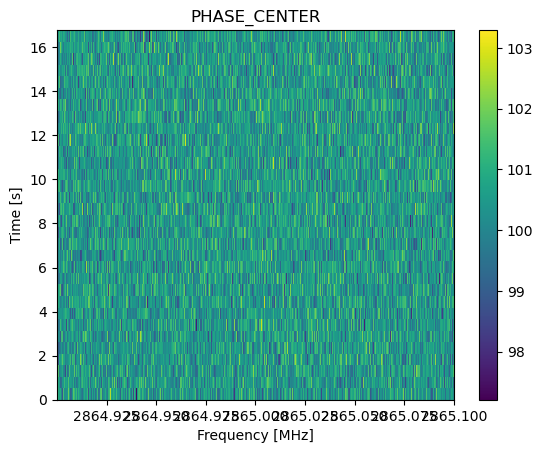

In [ ]:
frame = stg.Frame(
    filename='cosmic_subset.fil',
    fchans=4096,
    tchans=32,
    df=1.9073486328125e-6 * u.MHz,  # or 1.9073486328125 * u.uHz
    dt=0.524288 * u.s,
    fch1=2883.0 * u.MHz,
    load_data=True,
    ascending=False
)

frame.add_constant_signal(
    f_start=frame.get_frequency(3000),  # pick channel
    drift_rate=1.0 * u.Hz/u.s,
    level=frame.get_intensity(snr=50),  # depending on desired SNR
    width=5
)

frame.save_to_fil('cosmic_subset_injected.fil')



In [4]:
!seticore "/datax/scratch/jaym/data0005-beam0000.fil" --output "seticore_output/cosmic_fil.dat"

welcome to seticore, version 1.0.6
running in dedoppler mode.
loading input from /datax/scratch/jaym/data0005-beam0000.fil
dedoppler parameters: max_drift=10.00 min_drift=0.0000 snr=25.00
writing output to seticore_output/cosmic_fil.dat
attr name: machine_id
attr name: telescope_id
attr name: src_raj
attr name: src_dej
attr name: az_start
attr name: za_start
attr name: data_type
attr name: fch1
attr name: foff
attr name: nchans
attr name: nbeams
attr name: ibeam
attr name: nbits
attr name: tstart
attr name: tsamp
attr name: nifs
attr name: barycentric
attr name: pulsarcentric
attr name: source_name
attr name: rawdatafile
attr name: HEADER_END
TODO: implement FilReader::loadCoarseChannel


In [4]:
# Step 1: Load the real .fil file as a setigen Frame
frame = stg.Frame(
    filename='/datax/scratch/jaym/data0005-beam0000.fil',
    load_data=True
)

# (Optional) Check frequency axis or plot the waterfall
print(frame.fch1, frame.df, frame.fchans, frame.tchans)

# Step 2: Inject synthetic signal into the real background
frame.add_constant_signal(
    f_start=frame.get_frequency(2865),        # pick an appropriate bin
    drift_rate=2.0 * u.Hz/u.s,               # simulate Doppler drift
    level=frame.get_intensity(snr=30),       # signal strength
    width=4                                   # spectral width (bins)
)

# You can add multiple different signals if desired
# frame.add_gaussian_noise(...)  # don't need to, noise is already there!

# Step 3: Save the modified frame as a new .fil file
frame.save_to_fil('/datax/scratch/jaym/injected_cosmic_file.fil')


ValueError: Frame must be provided dimensions or an existing filterbank file.

In [ ]:
injected_fil = Waterfall('/datax/scratch/jaym/injected_cosmic_file.fil')

In [ ]:
fil.plot_waterfall(2864.9, 2865.1)